In [ ]:
#
# In this tutorial notebook, you will help me 
# writing your own Metropolis-Hasting Monte Carlo Simulation!
#
# Handed out: Th, 6/8/17
# Due:        Th, 6/22/17
# When you submit your answers, please also generate a pdf file of your ipynb session with results
# via "File"->"Download As"->"PDF via LaTex (.pdf)"
#
# Please complete all "TASK"s and "FIX ME"s
#

In [1]:
from ase.io import read
from ase import Atoms
from ase.optimize import *
from ase.visualize import view
from ase.md import *
from ase.calculators.mopac import *
from ase.constraints import *

import nglview
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

# install via "conda install seaborn libgfortran"
# used to plot distribution with histograms and kernel density estimates in a fancy way
import seaborn as sns

In [2]:
#
# In this tutorial notebook, you will explore Monte Carlo simulations
#
# Let's start with a system of one Cl and two Na ions in vacuum ...
#
instem = "Cl_2Na"

wdg_init = nglview.show_structure_file("input/%s.pdb" % (instem), format = "pdb")
wdg_init.add_representation('ball+stick')
wdg_init.center_view()
wdg_init.display(gui=True)

In [3]:
#
# ... and first perform a potential energy surface (PES) scan along the 
#     z-coordinates of the two Na ions (z1, z2)
#
calc = Mopac(restart=0, spin=0, OPT=False, functional='PM6', job_type='NOANCI 1SCF GRADIENTS AUX(0,PRECISION=9)', RELSCF=0.0001)
#calc = Mopac(restart=0, spin=0, OPT=False, functional='PM6', job_type='NOANCI CHARGE=-1 NOSYM 1SCF GRADIENTS AUX(0,PRECISION=9)', RELSCF=0.0001 )
#calc=Mopac(restart=0, spin=0, OPT=False, functional='PM6', job_type='NOANCI CHARGE=2 NOSYM 1SCF GRADIENTS AUX(0,PRECISION=9)', RELSCF=0.01 )

# load in the system in "xyz" format to speeden up computations
model = "%s" % (instem)
water   = read("input/%s.xyz" % (model), format="xyz")
molecule = Atoms(water)
mycharges = molecule.get_initial_charges()
molecule.set_calculator(calc)

# here, we use an index array to set ion z-coordinate(s) (see below)
# try to understand what I am doing here with this mask:
posinds = np.zeros(np.shape(molecule.positions), dtype = "bool")
# set index array for atom 1 and 2 (the two NAs) to "True"
posinds[1:3,2] = True

# distance between two atoms (here the two Na ions)
def get_dist(mol):
    a = 1
    b = 2
    return np.sqrt(np.sum((mol.positions[a] - mol.positions[b])**2))

starttime = time.time()
# two-dimensional potential energy scan:
a_pos  = np.linspace(-4, 4, 30)
a_pot  = np.ones(shape = np.shape(a_pos) + np.shape(a_pos), dtype = np.float64)
a_dist = np.ones(shape = np.shape(a_pos) + np.shape(a_pos), dtype = np.float64)
print np.shape(a_pot)
for i in range(len(a_pos)):
    print(i)
    for j in range(len(a_pos)):
        # here we use the index array
        molecule.positions[posinds] = [a_pos[i], a_pos[j]]
        a_dist[i,j] = get_dist(molecule)
        a_pot[i,j] = molecule.get_potential_energy()

endtime = time.time()
print "compututation took: %.1f secs." % (endtime - starttime)

(30, 30)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
compututation took: 227.0 secs.


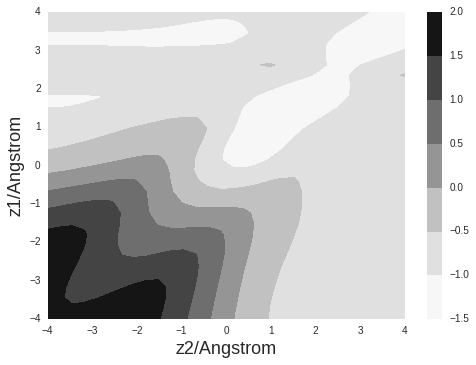

In [4]:
#
# Potential Energy Surface (PES)
#
# TASK:
# Make a 2D plot of the PES along (z1, z2)
# 
plt.ylabel('z1/Angstrom',fontsize=18)                
plt.xlabel('z2/Angstrom',fontsize=18) 
plt.contourf(a_pos,a_pos,a_pot)
plt.colorbar()
plt.show()

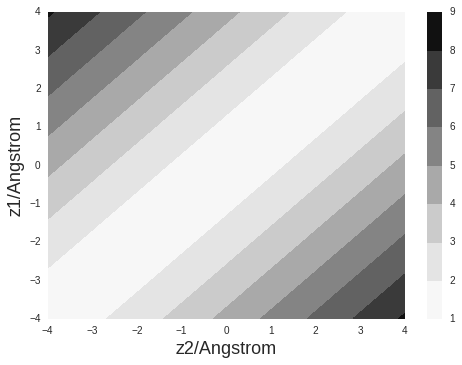

In [5]:
#
# Distance between the two Na atoms
# 
# TASK:
# Make a 2D plot of the distance between the two NA ions
#
# (Below, we are going to generate Boltzmann distributions of the distances)
#
plt.ylabel('z1/Angstrom',fontsize=18)                
plt.xlabel('z2/Angstrom',fontsize=18) 
plt.contourf(a_pos,a_pos,a_dist)
plt.colorbar()
plt.show()

In [6]:
#
# Below is a code skeleton to perform MCMC in multiple dimensions
# We use this code to sample distances between the two Na ions
#
def mcmc(mol, posinds, q, pbc, RT, step, n, skip):
    ''' multi-dimensional, molecular Markov Chain Monte Carlo (MCMC):
    mol     : ASE molecule object
    posinds : array mask used flexibly access the coordinates of interest
    q       : starting value of z-coordinate [nm]
    pbc     : for each coordinate, use periodic boundary conditions within the interval [-pbc,+pbc]
    RT      : scaling factor for the MCMC acceptance criterion, 
              i.e. product of gas constant R (or Boltzmann constant in molar units) and temperature
              a.k.a: inverse temperature beta = 1/RT
              [kJ/mol]
    step    : maximum absolute MCMC step size [nm]
    n       : number of MCMC steps
    skip    : print out progress every skip steps
    '''
    # sampled trajectory of z-coordinate
    s_traj  = np.zeros(shape = (n,) + np.shape(q), dtype=np.float64)
    # distances of sampled trajectory
    s_dist  = np.zeros(shape = (n,), dtype=np.float64)
    # potential energies of sampled trajectory
    s_pot  = np.zeros(shape = (n,), dtype=np.float64)
    # acceptances along sampled trajectory
    s_isacc = np.zeros(shape = (n,), dtype=np.bool)
    
    mol.positions[posinds] = q
    epot = mol.get_potential_energy()
    for i in range(n):
        if (i % skip) == 0:
            print("%.1f %%" % (1. * i / n * 100) )
        q_trial = q + step * 2.0 * (np.random.random_sample(np.shape(q)) - 0.5)
        # impose periodic boundary conditions from [-pbc/2.,+pbc/2.]
        q_trial = (q_trial + pbc) % (2 * pbc) - pbc
        # FIX ME (start)
        # write your own MCMC code for two dimensions!
        # - use your MCMC solution from notebook 05.01
        # - use code from the PES scan above as necessary
        # accept q_trial? For now, set accept to False, but if accept, set to True
        accept = False
        # set molecule position to q_trial
        mol.positions[posinds] = q_trial
        # potential energy of q_trial
        epot_trial = mol.get_potential_energy()
        
        #calculating delta_e
        delta_e = (epot_trial-epot)
        # Use the Metropolis-Hastings algorithm to accept or reject q_trial
        acceptance_probability = min(1.0,np.exp(-delta_e/RT))
        if np.random.random() < acceptance_probability:
            accept = True

        if accept:
            q = np.copy(q_trial)
            epot = epot_trial
        # FIX ME (end)
        s_isacc[i] = accept
        s_traj[i]  = q
        s_dist[i]  = get_dist(mol)
        s_pot[i]  = epot
    return s_traj, s_dist, s_pot, s_isacc

In [13]:
# periodic boundary conditions
pbc = 4
# randomly chosen value of q_init
q_init = np.random.rand(2) * pbc * 2

#
# TASK: 
# Find minimal parameter values below
# to generate three MCMC runs producing
# consistent Boltzmann distributions of the distance between the two Na ions.
# Don't forget to document your results.

#import simtk.unit as unit
#temperature = 310.0*unit.kelvin
#R = unit.BOLTZMANN_CONSTANT_kB*unit.AVOGADRO_CONSTANT_NA
#RT = R*temperature # this is the relevant energy scale
#RT.value_in_unit(unit.kilojoule_per_mole)
#RT.value_in_unit(unit.kilocalorie_per_mole)
RT = 0.6160340502099109/3 # Boltzmann constant [kcal/mol]

step = 4.0 #initial: 0.5

n = 100

skip = 50

starttime = time.time()
s_traj, s_dist, s_pot, s_isacc = mcmc(molecule, posinds, q_init, pbc, RT, step, n, skip)
endtime = time.time()
print "compututation took: %.1f secs." % (endtime - starttime)

0.0 %
50.0 %
compututation took: 25.4 secs.


In [14]:
# compute the acceptance rate again
1. * s_isacc.sum() / len(s_isacc)

0.36

(3.1257232506111312, 1.5343409856888401)

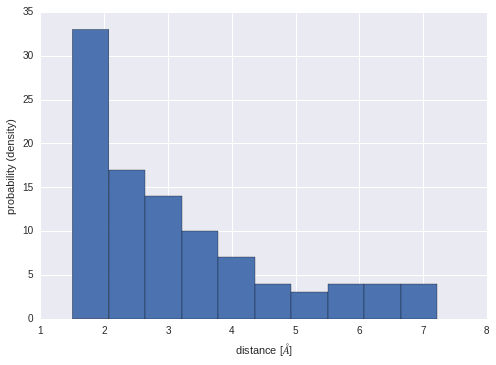

In [9]:
#
# plot a histogram and a kernel density estimate of Na-Na distances
# First Run:
#
#fig = sns.distplot(s_dist);
#fig.set(xlabel=r'distance [$\AA$]', ylabel='probability (density)')
fig = plt.hist(s_dist)
plt.xlabel(r'distance [$\AA$]')
plt.ylabel('probability (density)')
s_dist.mean(), s_dist.std()

In [ ]:
# for the set of minimal parameter values, execute the above cells three times
# - do the three distributions and their means/standard dvaitions look consistent?
# for the initial step size of 0.5 the distributions were not consistent. With a step size of 4.0 and reduced
# temperature a the distributions are more consistent. The means are between 3.1 and 3.3 and the standard 
# deviations are between 1.4 and 1.5.

(3.1499278733875169, 1.3880111564740865)

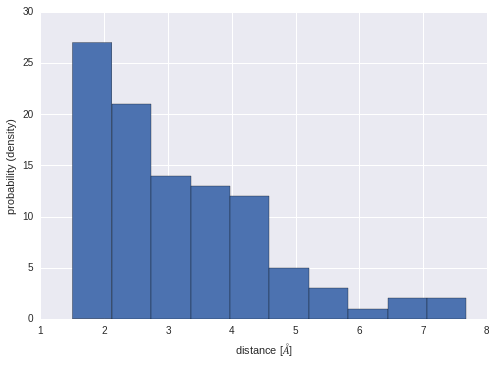

In [12]:
#
# plot a histogram and a kernel density estimate of Na-Na distances
# Second Run:
#
#fig = sns.distplot(s_dist);
#fig.set(xlabel=r'distance [$\AA$]', ylabel='probability (density)')
fig = plt.hist(s_dist)
plt.xlabel(r'distance [$\AA$]')
plt.ylabel('probability (density)')
s_dist.mean(), s_dist.std()

(3.3360615227567809, 1.5520767875125665)

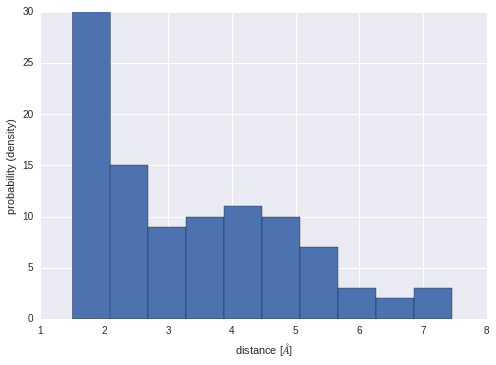

In [15]:
#
# plot a histogram and a kernel density estimate of Na-Na distances
# Third Run:
#
#fig = sns.distplot(s_dist);
#fig.set(xlabel=r'distance [$\AA$]', ylabel='probability (density)')
fig = plt.hist(s_dist)
plt.xlabel(r'distance [$\AA$]')
plt.ylabel('probability (density)')
s_dist.mean(), s_dist.std()

In [ ]:
#
# TASK:
# a)
# Now directly compute the mean and standard deviation of
# the Boltzmann distribution of distances, as sampled with MCMC above,
# but this time as an integral (in fact a sum) over the grid points defined by a_pos
#
# Hints: 
# - you will need a_pot, a_dist, and RT to compute this sum
# - the integral of dx * exp(x), or the sum of exp(x) over an array x, 
#   e.g., covering the interval [-4,4], is np.sum(np.exp(x))
#   (np.exp(x) will give you an array with the same dimensions as in x
#   and elements np.exp(x_ij) for each each element x_ij of x)
#
# FIX ME (start):
mean=np.sum((np.exp(-a_pot/RT)*a_dist))/np.sum(np.exp(-a_pot/RT))
dev=np.sqrt(np.sum((np.exp(-a_pot/RT)*a_dist**2))/np.sum(np.exp(-a_pot/RT))-mean**2)
print "mean: %g" % mean
print "standard deviation: %g" % dev
# FIX ME (end):

# b)
# What are the mean and standard deviation of this distribution?
# How do these compare to the distribution sampled with MCMC?
# ANSWER:
# The mean is 3.48 wich is a bit larger than the mean from the MCMC. Also the standard variation of 1.8
# is larger than the standard deviation from MCMC.
#
#
# FYI:
# As above, we can plot the underlying Boltzmann distribution
# with a special trick:
abc = 1/(np.exp(-a_pot/RT) / np.exp(-a_pot / RT).sum())
abc /= abc.min()
l = [int(x) * [y] for x,y in zip(np.round(abc).flatten(), a_dist.flatten())]
#fig = sns.distplot([item for sublist in l for item in sublist]);
#fig.set(xlabel=r'distance [$\AA$]', ylabel='probability (density)')
fig = plt.hist([item for sublist in l for item in sublist])
plt.xlabel(r'distance [$\AA$]')
plt.ylabel('probability (density)')

#
# FYI:
# For much higher dimensions, potential energy scans as in
# in our two dimensional case above become computationally prohibitive.
# Thus, sampling of the Boltzmann distribution, e.g. via MCMC, become the only 
# feasible computational option, as the MCMC algorithm more likely samples
# lower-energy states that are contributing with exponentially higher weights
# to Boltzmann distribution
#

mean: 2.74306
standard deviation: 1.75133
